# 03｜为 LangGraph Chatbot 添加人机交互控制（Human-in-the-Loop）

本教程在"记忆功能"基础上，使用 LangGraph 的 `interrupt` 函数添加人机交互控制，允许在执行过程中暂停并等待人工输入。

核心思路：
- 创建 `human_assistance` 工具，使用 `interrupt()` 暂停执行
- 工具调用时暂停，等待人工反馈
- 使用 `Command(resume=...)` 恢复执行并传递人工输入

应用场景：
- 需要人工审批的敏感操作
- 复杂决策需要专家指导
- 不确定情况下的安全控制

## 1. 安装/升级依赖

与前面教程相同的依赖，确保已安装所需包：

```python
%pip install -U langgraph langsmith "langchain[openai]" langchain-tavily python-dotenv
```

In [22]:
# 安装依赖（如已安装可跳过）
# %pip install -U langgraph langsmith "langchain[openai]" langchain-tavily python-dotenv

## 2. 环境配置（沿用前面的 OpenRouter 配置）

继续使用 OpenRouter 作为 OpenAI 兼容端点来访问多种模型。

In [23]:
import os
from dotenv import load_dotenv

# 加载 .env 文件
load_dotenv()

# 强制使用 OPENROUTER_API_KEY 作为 OPENAI_API_KEY
if os.getenv("OPENROUTER_API_KEY"):
    os.environ["OPENAI_API_KEY"] = os.environ["OPENROUTER_API_KEY"]

from langchain.chat_models import init_chat_model

BASE_URL = os.getenv("OPENAI_BASE_URL", "https://openrouter.ai/api/v1")
MODEL_ID = os.getenv("OPENROUTER_MODEL", "openai:gpt-4o-mini")

llm = init_chat_model(MODEL_ID, base_url=BASE_URL)
print("模型已就绪:", MODEL_ID, "通过", BASE_URL)

模型已就绪: openai:gpt-4o-mini 通过 https://openrouter.ai/api/v1


## 3. 添加 `human_assistance` 工具

核心创新：创建一个使用 `interrupt()` 的工具，可以暂停图的执行并等待人工输入。

### 3.1 理解 `interrupt()` 函数

- **作用**: 类似 Python 的 `input()`，但支持分布式暂停/恢复
- **机制**: 暂停执行，保存状态到 checkpointer
- **恢复**: 通过 `Command(resume=...)` 传递人工输入并继续执行

In [24]:
from typing import Annotated
from typing_extensions import TypedDict

from langchain_tavily import TavilySearch
from langchain_core.tools import tool
from langgraph.checkpoint.memory import InMemorySaver
from langgraph.graph import StateGraph, START
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode, tools_condition
from langgraph.types import Command, interrupt

# 定义 State
class State(TypedDict):
    messages: Annotated[list, add_messages]

graph_builder = StateGraph(State)

# 🔥 核心：human_assistance 工具
@tool
def human_assistance(query: str) -> str:
    """请求人工协助。"""
    print(f"🤖 AI 请求人工协助: {query}")
    
    # interrupt() 会暂停图的执行，保存状态，等待人工输入
    human_response = interrupt({"query": query})
    
    # 恢复执行时，human_response 包含通过 Command 传递的数据
    return human_response["data"]

# 准备工具列表
search_tool = TavilySearch(max_results=2)
tools = [search_tool, human_assistance]  # 新增 human_assistance

# 绑定工具到 LLM
llm_with_tools = llm.bind_tools(tools)

def chatbot(state: State):
    message = llm_with_tools.invoke(state["messages"])
    
    # ⚠️ 重要：禁用并行工具调用，避免中断时重复执行
    assert len(message.tool_calls) <= 1, "请禁用并行工具调用以支持中断"
    
    return {"messages": [message]}

# 构建图
graph_builder.add_node("chatbot", chatbot)

tool_node = ToolNode(tools=tools)
graph_builder.add_node("tools", tool_node)

graph_builder.add_conditional_edges(
    "chatbot",
    tools_condition,
)
graph_builder.add_edge("tools", "chatbot")
graph_builder.add_edge(START, "chatbot")

print("图结构:", graph_builder)

图结构: <langgraph.graph.state.StateGraph object at 0x119c58d60>


## 4. 编译图（带检查点支持）

人机交互功能依赖检查点系统来保存和恢复状态。

In [25]:
memory = InMemorySaver()
graph = graph_builder.compile(checkpointer=memory)
print("图已编译完成，支持检查点人机交互功能。")

图已编译完成，支持检查点人机交互功能。


## 5. 可视化图结构（可选）

图的结构与之前相同，只是多了一个 `human_assistance` 工具。

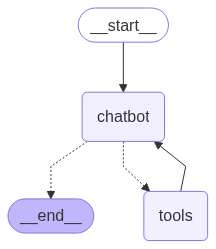

In [26]:
# 可视化图结构
try:
    from IPython.display import Image, display
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception as e:
    print(f"图可视化需要额外依赖，跳过: {e}")
    print("图结构: START -> chatbot -> [条件边] -> tools -> chatbot")

## 6. 触发人工协助请求

让我们提一个会触发 `human_assistance` 工具的问题：

In [33]:
user_input = "我需要一些关于构建 AI 智能体的专家指导，你能帮我请求协助吗？"
config = {"configurable": {"thread_id": "human_loop_demo"}}

print("🚀 开始对话，等待人工协助...")

events = graph.stream(
    {"messages": [{"role": "user", "content": user_input}]},
    config,
    stream_mode="values",
)

for event in events:
    if "messages" in event:
        last_msg = event["messages"][-1]
        print(f"\n📨 {type(last_msg).__name__}:")
        last_msg.pretty_print()

🚀 开始对话，等待人工协助...

📨 HumanMessage:
================================ Human Message =================================

我需要一些关于构建 AI 智能体的专家指导，你能帮我请求协助吗？

📨 AIMessage:
================================== Ai Message ==================================
Tool Calls:
  human_assistance (call_OXGqrBR0GOrMj0t5wGJPActo)
 Call ID: call_OXGqrBR0GOrMj0t5wGJPActo
  Args:
    query: 我需要一些关于构建 AI 智能体的专家指导，请问有哪些建议或资源推荐？


### 6.1 检查图的中断状态

执行会在 `tools` 节点暂停，等待人工输入：

In [28]:
snapshot = graph.get_state(config)
print("当前状态:")
print(f"下一步执行的节点: {snapshot.next}")
print(f"消息数量: {len(snapshot.values.get('messages', []))}")

# 如果图在等待，next 应该是 ('tools',)
if snapshot.next:
    print("✋ 图已暂停，等待人工输入恢复执行")
else:
    print("✅ 图执行完成")

当前状态:
下一步执行的节点: ('tools',)
消息数量: 2
✋ 图已暂停，等待人工输入恢复执行


## 7. 恢复执行（提供人工输入）

使用 `Command(resume=...)` 传递人工响应并恢复图的执行：

In [29]:
# 🧑‍💼 模拟专家的人工响应
human_response = (
    "我们专家团队来帮助您了！我们建议您查看 LangGraph 来构建您的智能体。"
    "它比简单的自主智能体更可靠、更具扩展性。"
    "LangGraph 提供：1) 状态管理，2) 检查点机制，3) 人机交互工作流，"
    "4) 高级路由和条件逻辑。"
)

# 创建 Command 对象来恢复执行
human_command = Command(resume={"data": human_response})

print("👨‍💼 专家提供回应，恢复执行...")

# 恢复图的执行
events = graph.stream(human_command, config, stream_mode="values")

for event in events:
    if "messages" in event:
        last_msg = event["messages"][-1]
        print(f"\n📨 {type(last_msg).__name__}:")
        last_msg.pretty_print()

👨‍💼 专家提供回应，恢复执行...

📨 AIMessage:
================================== Ai Message ==================================
Tool Calls:
  human_assistance (call_xrnRUKuQe2BE8pE6UxBoVFBM)
 Call ID: call_xrnRUKuQe2BE8pE6UxBoVFBM
  Args:
    query: 我需要一些关于构建 AI 智能体的专家指导和建议。
🤖 AI 请求人工协助: 我需要一些关于构建 AI 智能体的专家指导和建议。

📨 ToolMessage:
================================= Tool Message =================================
Name: human_assistance

我们专家团队来帮助您了！我们建议您查看 LangGraph 来构建您的智能体。它比简单的自主智能体更可靠、更具扩展性。LangGraph 提供：1) 状态管理，2) 检查点机制，3) 人机交互工作流，4) 高级路由和条件逻辑。

📨 AIMessage:
================================== Ai Message ==================================

我已请求专家协助，专家推荐您查看 LangGraph 来构建 AI 智能体。LangGraph 提供以下功能，使其比简单的自主智能体更可靠且更具扩展性：

1. **状态管理**：有效跟踪和管理智能体的状态。
2. **检查点机制**：确保在需要时可以恢复到先前的状态。
3. **人机交互工作流**：支持与用户的交互，提升智能体的用户体验。
4. **高级路由和条件逻辑**：实现复杂的决策逻辑和任务路由。

这些功能能够帮助您更高效地构建和管理 AI 智能体。


### 7.1 验证执行完成

检查图是否已完全恢复并完成执行：

In [30]:
final_snapshot = graph.get_state(config)
print("执行完成后的状态:")
print(f"下一步节点: {final_snapshot.next}")
print(f"总消息数: {len(final_snapshot.values.get('messages', []))}")

if not final_snapshot.next:
    print("✅ 图执行完成！人工协助流程成功完成。")
else:
    print("⚠️ 图仍在等待或执行中...")

执行完成后的状态:
下一步节点: ()
总消息数: 4
✅ 图执行完成！人工协助流程成功完成。


## 8. 深入理解 Human-in-the-Loop 机制

### 8.1 核心概念

1. **`interrupt()` 函数**:
   - 暂停图的执行
   - 保存当前状态到 checkpointer
   - 返回传递给它的数据结构

2. **`Command(resume=...)` 对象**:
   - 恢复被中断的执行
   - 传递人工输入数据
   - 支持复杂的数据结构

3. **检查点持久化**:
   - 状态可以无限期保存
   - 支持跨进程、跨时间恢复
   - 生产环境可用 PostgreSQL/SQLite

### 8.2 工作流程

```
用户输入 → AI决策 → 需要人工协助 → interrupt() → 暂停执行
                                                    ↓
人工响应 ← Command(resume=...) ← 等待人工输入 ← 保存状态
    ↓
恢复执行 → 处理人工输入 → 生成最终回复 → 完成
```

### 8.3 实际应用场景

1. **敏感操作审批**:
   - 删除数据前确认
   - 发送邮件前审核
   - 执行系统命令前验证

2. **专家咨询**:
   - 复杂技术问题
   - 医疗诊断建议
   - 法律意见咨询

3. **质量控制**:
   - 内容审核
   - 代码review
   - 创意方案评估

4. **学习系统**:
   - 收集人工标注
   - 获取用户反馈
   - 改进模型输出

## 9. 高级示例：条件中断

让我们创建一个更智能的人工协助工具，只在特定条件下中断：

In [31]:
# 🚀 高级示例：智能人工协助工具
@tool
def smart_human_assistance(query: str, urgency: str = "normal") -> str:
    """
    智能人工协助工具，根据紧急程度决定是否中断
    
    Args:
        query: 需要协助的问题
        urgency: 紧急程度 ("low", "normal", "high", "critical")
    """
    
    # 只有 high 或 critical 级别才中断，其他情况自动处理
    if urgency.lower() in ["high", "critical"]:
        print(f"🚨 {urgency.upper()} 级别请求，需要人工协助: {query}")
        human_response = interrupt({
            "query": query, 
            "urgency": urgency,
            "timestamp": "2025-08-12T10:30:00Z"
        })
        return human_response["data"]
    else:
        # 低优先级自动回复
        return f"这是一个 {urgency} 级别的问题，AI 自动处理: 建议查看相关文档或联系技术支持。"

# 测试不同紧急程度
print("=== 测试智能人工协助工具 ===")

# 测试1: 低优先级（不会中断）
try:
    # 低优先级不会触发中断，可以直接测试
    result1 = smart_human_assistance("如何使用基础功能？", "low")
    print(f"低优先级结果: {result1}")
except Exception as e:
    print(f"低优先级测试异常（这是预期内的，因为不在图执行上下文中）: {type(e).__name__}")

# 添加高优先级的测试说明
print("\n高优先级测试需要在图执行中进行，下面是如何在实际应用中使用:")
print("""
# 在图中使用示例:
config = {"configurable": {"thread_id": "urgent_demo"}}
user_msg = "我需要紧急帮助处理这个安全漏洞问题"

# 启动图执行
events = graph.stream(
    {"messages": [{"role": "user", "content": user_msg}]},
    config,
    stream_mode="values"
)

# 图会在 smart_human_assistance 工具被调用（且紧急级别为 high/critical）时暂停
# 然后可以通过 Command 对象恢复执行:
# graph.stream(Command(resume={"data": "人工专家回复内容"}), config)
""")

=== 测试智能人工协助工具 ===
低优先级测试异常（这是预期内的，因为不在图执行上下文中）: AttributeError

高优先级测试需要在图执行中进行，下面是如何在实际应用中使用:

# 在图中使用示例:
config = {"configurable": {"thread_id": "urgent_demo"}}
user_msg = "我需要紧急帮助处理这个安全漏洞问题"

# 启动图执行
events = graph.stream(
    {"messages": [{"role": "user", "content": user_msg}]},
    config,
    stream_mode="values"
)

# 图会在 smart_human_assistance 工具被调用（且紧急级别为 high/critical）时暂停
# 然后可以通过 Command 对象恢复执行:
# graph.stream(Command(resume={"data": "人工专家回复内容"}), config)



## 10. Bonus：完整代码整合

以下是完整的人机交互聊天机器人代码：

In [32]:
# 完整的人机交互聊天机器人
import os
from typing import Annotated
from typing_extensions import TypedDict
from dotenv import load_dotenv

from langchain.chat_models import init_chat_model
from langchain_tavily import TavilySearch
from langchain_core.tools import tool
from langgraph.checkpoint.memory import InMemorySaver
from langgraph.graph import StateGraph, START
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode, tools_condition
from langgraph.types import Command, interrupt

# 环境配置
load_dotenv()
if os.getenv("OPENROUTER_API_KEY"):
    os.environ["OPENAI_API_KEY"] = os.environ["OPENROUTER_API_KEY"]

BASE_URL = os.getenv("OPENAI_BASE_URL", "https://openrouter.ai/api/v1")
MODEL_ID = os.getenv("OPENROUTER_MODEL", "openai:gpt-4o-mini")
llm = init_chat_model(MODEL_ID, base_url=BASE_URL)

# State 定义
class State(TypedDict):
    messages: Annotated[list, add_messages]

# 人工协助工具
@tool
def human_assistance(query: str) -> str:
    """请求人工协助。"""
    human_response = interrupt({"query": query})
    return human_response["data"]

# 构建图
graph_builder = StateGraph(State)

search_tool = TavilySearch(max_results=2)
tools = [search_tool, human_assistance]
llm_with_tools = llm.bind_tools(tools)

def chatbot(state: State):
    message = llm_with_tools.invoke(state["messages"])
    assert len(message.tool_calls) <= 1, "禁用并行工具调用"
    return {"messages": [message]}

graph_builder.add_node("chatbot", chatbot)
graph_builder.add_node("tools", ToolNode(tools=tools))
graph_builder.add_conditional_edges("chatbot", tools_condition)
graph_builder.add_edge("tools", "chatbot")
graph_builder.add_edge(START, "chatbot")

# 编译图
memory = InMemorySaver()
graph = graph_builder.compile(checkpointer=memory)

# 使用示例
def demo_human_in_loop():
    """演示人机交互功能"""
    config = {"configurable": {"thread_id": "demo"}}
    
    print("🤖 用户请求专家指导...")
    events = graph.stream(
        {"messages": [{"role": "user", "content": "我需要关于 AI 系统的专家指导。"}]},
        config,
        stream_mode="values"
    )
    
    for event in events:
        if "messages" in event:
            event["messages"][-1].pretty_print()
    
    # 检查是否需要人工输入
    snapshot = graph.get_state(config)
    if snapshot.next:
        print("\n⏸️ 图已暂停，等待人工输入...")
        
        # 模拟专家回复
        expert_response = "AI 系统设计建议：1) 使用模块化架构，2) 实现监控和日志，3) 考虑安全性，4) 优化性能。"
        
        # 恢复执行
        print("👨‍💼 专家提供建议，恢复执行...")
        events = graph.stream(Command(resume={"data": expert_response}), config, stream_mode="values")
        
        for event in events:
            if "messages" in event:
                event["messages"][-1].pretty_print()

# 如果需要测试，取消下面的注释
demo_human_in_loop()

🤖 用户请求专家指导...
================================ Human Message =================================

我需要关于 AI 系统的专家指导。
================================== Ai Message ==================================
Tool Calls:
  human_assistance (call_KPf5yMipYGm5IblQ85ld14Yq)
 Call ID: call_KPf5yMipYGm5IblQ85ld14Yq
  Args:
    query: 我需要关于 AI 系统的专家指导。

⏸️ 图已暂停，等待人工输入...
👨‍💼 专家提供建议，恢复执行...
================================== Ai Message ==================================
Tool Calls:
  human_assistance (call_KPf5yMipYGm5IblQ85ld14Yq)
 Call ID: call_KPf5yMipYGm5IblQ85ld14Yq
  Args:
    query: 我需要关于 AI 系统的专家指导。
================================= Tool Message =================================
Name: human_assistance

AI 系统设计建议：1) 使用模块化架构，2) 实现监控和日志，3) 考虑安全性，4) 优化性能。
================================== Ai Message ==================================

关于 AI 系统的设计与实现，以下是一些专家指导建议：

1. **模块化架构**：采用模块化设计可以让系统更具灵活性和可维护性。不同模块可以独立开发、测试和部署，从而加速开发流程。

2. **监控和日志**：实现实时监控和详细日志记录，以便于追踪系统性能和快速诊断问题。这有助于识别瓶颈和潜在的安全风险。

3. **安全性考虑**：

## 🎉 总结

恭喜！你已经成功实现了带有人机交互控制的 LangGraph 聊天机器人！

### ✅ 学到的核心技能：

1. **`interrupt()` 函数使用**：暂停图执行，等待人工输入
2. **`Command(resume=...)` 对象**：恢复执行并传递人工数据  
3. **检查点持久化**：支持长期暂停和跨会话恢复
4. **工具级别的人机交互**：在特定工具中集成人工决策

### 🚀 关键优势：

- **灵活控制**：可以在任何节点暂停等待人工输入
- **状态持久**：支持无限期暂停，生产环境可用数据库存储
- **无缝恢复**：人工输入后自然继续执行流程
- **工作流集成**：与现有的工具和条件逻辑完美融合

### 🔮 下一步探索：

- **自定义 State**：添加更多字段来支持复杂的工作流
- **多轮人机交互**：支持多次暂停和人工介入
- **UI 集成**：构建 Web 界面来处理人工输入
- **权限控制**：不同用户级别的不同审批流程

人机交互是 AI 系统的重要安全机制，让你可以在关键决策点加入人工智慧！🧠✨